In [ ]:
#  core
import pandas as pd
import numpy as np
import joblib
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
# dataset
from sklearn.datasets import load_digits
# modelling
# classification
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, balanced_accuracy_score, ConfusionMatrixDisplay
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Data Analysis Pepeline:
1. Data Exploration
2. Data Cleaning
3. EDA (Visualisation)
4. Modeling
5. Model Evaluation
6. Model Deployment

# **STEP 1: Data Exploration**

## **Column Descriptions**

> Dataset Name: Kaggle MNIST Digit Recognizer
- Images: 28x28 grayscale images (i.e., 784 pixels per image)
- Total Images (Train): 42,000 samples
- Classes: 10 digits (0–9)

> Data Shape:
- Train Set: (42000, 785) → 784 pixel columns + 1 label column (label)
- Test Set: (28000, 784) → 784 pixel columns (no label)

> When converted into a Pandas DataFrame:

label:
- The actual digit (0–9) corresponding to the handwritten image
- Present only in train.csv

pixel0 to pixel783:
- Each represents a pixel in the 28x28 image (flattened row-wise)
- Values: Range from 0 (white) to 255 (black)
- Stored in 784 columns

## **Descriptive Statistics**

> Descriptive statistics summarize and describe the key features of a dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading the dataset

# train = pd.read_csv('C:/Users/ARZ/Desktop/train.csv')
# test = pd.read_csv('C:/Users/ARZ/Desktop/test.csv')
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
def quick_overview(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "nunique": df.nunique(),
        "missing": df.isnull().sum()
    }).reset_index().rename(columns={"index": "column"})
quick_overview(train)

,column,dtype,nunique,missing
0,label,int64,10,0
1,pixel0,int64,1,0
2,pixel1,int64,1,0
3,pixel2,int64,1,0
4,pixel3,int64,1,0
...,...,...,...,...
780,pixel779,int64,3,0
781,pixel780,int64,1,0
782,pixel781,int64,1,0
783,pixel782,int64,1,0


In [ ]:
def check_df(df, target=None, head=3):
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 500)

    print("#################### SHAPE ########################")
    print(f"🔹 Rows: {df.shape[0]} | 🔹 Columns: {df.shape[1]}\n")

    print("#################### INFO #########################")
    print(df.info(), "\n")

    print("################## DESCRIPTIVE STATS (numerical) ##################")
    display(df.describe().style.background_gradient(cmap='PuBu'))

    print("################## DUPLICATES ##################")
    print(f"🔁 Duplicate Rows: {df.duplicated().sum()}\n")

    if target and target in df.columns:
        print("############ TARGET DISTRIBUTION ############")
        print(df[target].value_counts(), "\n")

check_df(train, target= 'label')

#################### SHAPE ########################
🔹 Rows: 42000 | 🔹 Columns: 785

#################### INFO #########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None 

################## DESCRIPTIVE STATS (numerical) ##################


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

################## DUPLICATES ##################
🔁 Duplicate Rows: 0

############ TARGET DISTRIBUTION ############
label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64 



# **STEP 2: Data Cleaning**

### **1️⃣Handle missing values**

In [ ]:
# sanity check
train.isnull().sum()[train.isnull().sum() > 0]

,0


### **2️⃣ Remove duplicates**

In [ ]:
# sanity check
train.duplicated().sum()

np.int64(0)

# **STEP 3: EDA**

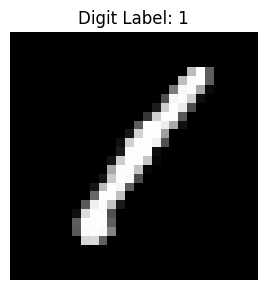

In [ ]:
# quick snapshot of the first image

plt.figure(figsize=(6,3))
img = train.iloc[0,1:].values.reshape(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f"Digit Label: {train.iloc[0,0]}")
plt.tight_layout()
plt.show()

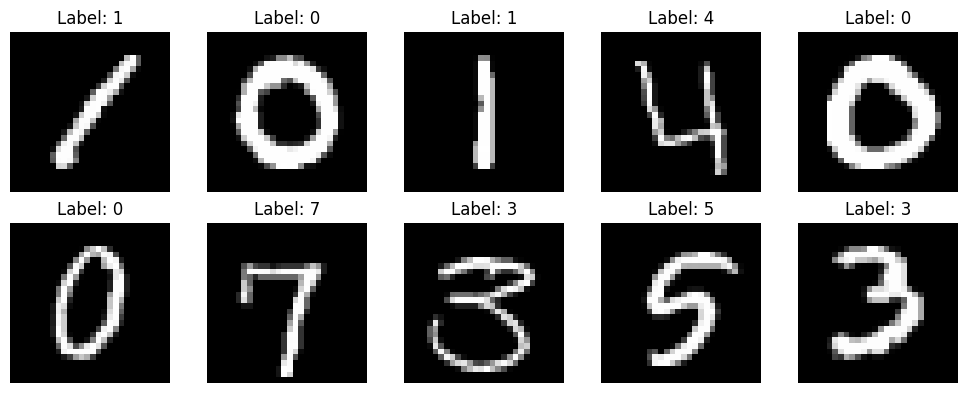

In [ ]:
# Digits Grid – sanity‑check labels & pixel range

fig, axes = plt.subplots(2, 5, figsize=(10,4))
for index, ax in enumerate(axes.ravel()):
    img = train.iloc[index, 1:].values.reshape(28,28)
    label = train.iloc[index, 0]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()

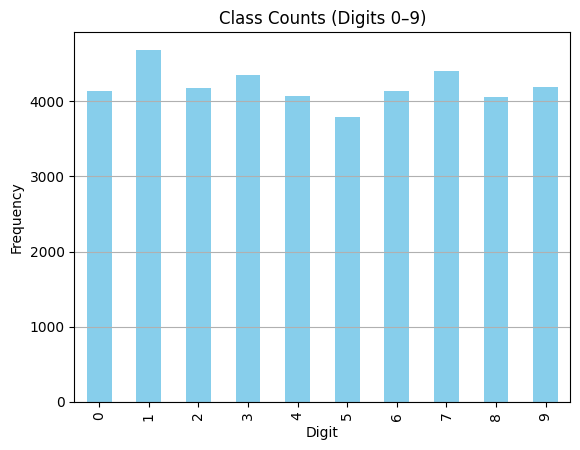

In [ ]:
# Target Distribution

train['label'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Class Counts (Digits 0–9)")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

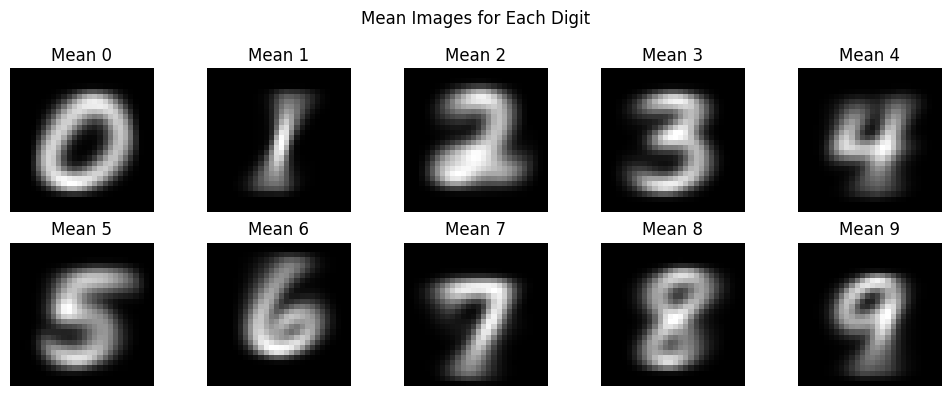

In [ ]:
# Average Image per Digit Class

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for digit in range(10):
    digit_pixels = train[train['label'] == digit].iloc[:, 1:]
    mean_image = digit_pixels.mean().values.reshape(28, 28)

    ax = axes[digit // 5, digit % 5]
    ax.imshow(mean_image, cmap='gray')
    ax.set_title(f"Mean {digit}")
    ax.axis('off')
plt.suptitle("Mean Images for Each Digit")
plt.tight_layout()

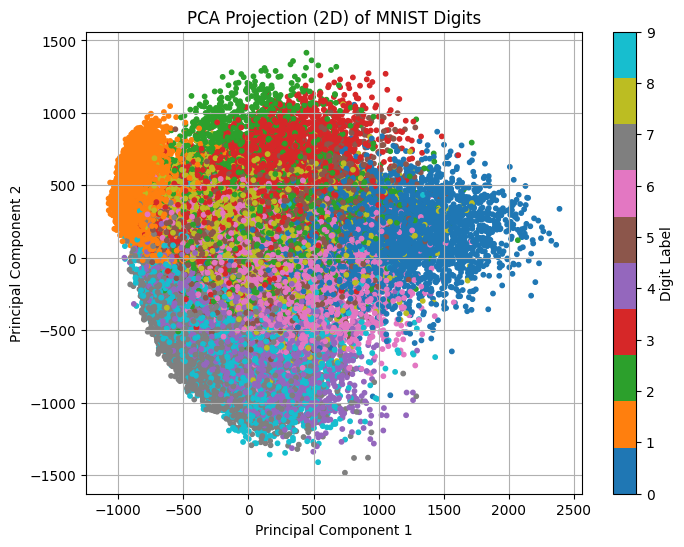

In [ ]:
# 2‑D projection (PCA or t‑SNE) – shows separability

# Reduce dimensionality of pixel data (skip the label)
X = train.iloc[:, 1:].values
y = train['label'].values

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=10, cmap='tab10')
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.title("PCA Projection (2D) of MNIST Digits")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# **STEP 4: Modeling**

In [ ]:
# Splitting Data into Training, Validation, and Test Sets

# Define Features (X) and Target (y)

# ------------------------------
# ML
# ------------------------------

# X = train.iloc[:,1:]  # Drop target column to keep pixel features
# y = train.iloc[:,0]   # Target is the digit label (0–9)

# ------------------------------
# DL
# ------------------------------

X = train.iloc[:,1:].values # pixels
y = train.iloc[:,0].values # labels
X = X / 255.0
X = X.reshape(-1,28,28,1)
y = to_categorical(y, num_classes=10)

In [ ]:
# Split into Train (80%), and Test (20%)

# ------------------------------
# ML
# ------------------------------

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ------------------------------
# DL
# ------------------------------

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, stratify=y.argmax(axis=1), random_state=42)
print(X.shape, y.shape)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(42000, 28, 28, 1) (42000, 10)


((33600, 28, 28, 1), (8400, 28, 28, 1), (33600, 10), (8400, 10))

In [ ]:
# ------------------------------
# ML
# ------------------------------

# to avoid data leakage and ensure that our model generalizes well.
scaler = StandardScaler()
# computing the mean and std only from the training set, avoiding data leakage.
X_train_scaled = scaler.fit_transform(X_train)  # ✅ Fit on training data
X_val_scaled  = scaler.transform(X_val) # ✅ Transform validation (unseen) data
X_test_scaled = scaler.transform(test) # ✅ Transform Kaggle test data (also unseen)
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved successfully!")

In [ ]:
# ------------------------------
# ML
# ------------------------------

# Define regression models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=30, max_features="sqrt", random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42,n_jobs=-1)
}

# Evaluate models
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # ✅ Train on SEEN data (80%)
    y_pred = model.predict(X_val_scaled) # 🔮 Predict on UNSEEN validation data (20%)

    summary = {
        "Model": name,
        "Accuracy": round(accuracy_score(y_val, y_pred), 4),
        "Precision": round(precision_score(y_val, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_val, y_pred, average='macro'), 4),
        "F1 Score": round(f1_score(y_val, y_pred, average='macro'), 4),
    }

    results.append(summary)

# Create results DataFrame
digits_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
digits_df

,Model,Accuracy,Precision,Recall,F1 Score
4,XGBoost,0.9733,0.9732,0.9731,0.9731
1,Random Forest,0.9563,0.9558,0.9558,0.9557
2,KNN,0.9375,0.9377,0.9365,0.9367
0,Logistic Regression,0.9036,0.9025,0.9022,0.9023
3,Decision Tree,0.8552,0.8536,0.8536,0.8536


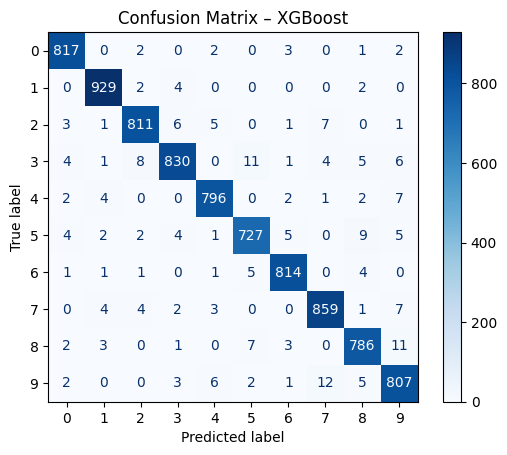

classification Report for XGBoost
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       827
           1       0.98      0.99      0.99       937
           2       0.98      0.97      0.97       835
           3       0.98      0.95      0.97       870
           4       0.98      0.98      0.98       814
           5       0.97      0.96      0.96       759
           6       0.98      0.98      0.98       827
           7       0.97      0.98      0.97       880
           8       0.96      0.97      0.97       813
           9       0.95      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [ ]:
# ------------------------------
# ML
# ------------------------------

best_model = models[digits_df.iloc[0]['Model']]
y_pred = best_model.predict(X_val_scaled)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap='Blues')
plt.title(f"Confusion Matrix – {digits_df.iloc[0]['Model']}")
plt.show()
print(f"classification Report for {digits_df.iloc[0]['Model']}")
print(classification_report(y_val, y_pred))

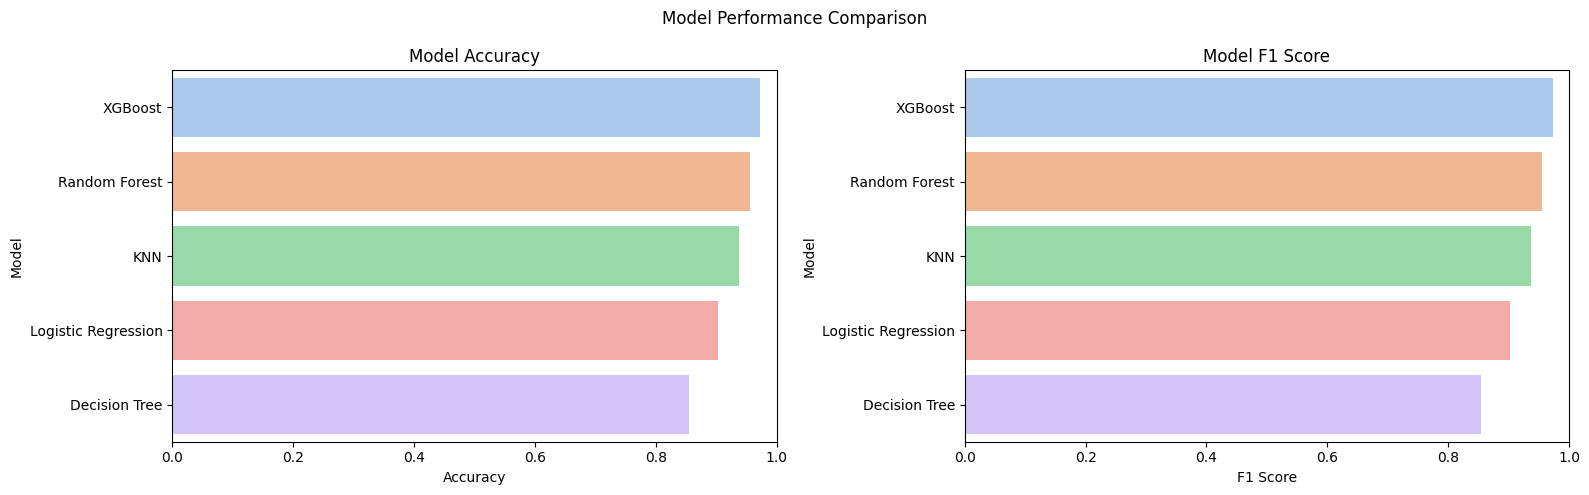

In [ ]:
# ------------------------------
# ML
# ------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(y=digits_df['Model'], x=digits_df['Accuracy'], palette='pastel', ax=axes[0])
axes[0].set_title("Model Accuracy")
axes[0].set_xlim(0, 1)

sns.barplot(y=digits_df['Model'], x=digits_df['F1 Score'], palette='pastel', ax=axes[1])
axes[1].set_title("Model F1 Score")
axes[1].set_xlim(0, 1)

plt.suptitle("Model Performance Comparison")
plt.tight_layout()
plt.show()

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 72s 195ms/step - accuracy: 0.7192 - loss: 0.8786 - learning_rate: 0.0010
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 68s 207ms/step - accuracy: 0.9298 - loss: 0.2212 - learning_rate: 0.0010
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 78s 195ms/step - accuracy: 0.9439 - loss: 0.1742 - learning_rate: 0.0010
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 66s 201ms/step - accuracy: 0.9557 - loss: 0.1418 - learning_rate: 0.0010
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9610 - loss: 0.1229 - learning_rate: 0.0010
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 85s 206ms/step - accuracy: 0.9660 - loss: 0.1099 - learning_rate: 0.0010
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 198ms/step - accuracy: 0.9677 - loss: 0.1045 - learning_rate: 0.0010
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 89s 220ms/step - accuracy: 0.9663 - loss: 0.1057 - learning_rate: 0.0010
Epoch 9/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - accuracy: 0.9706 - loss: 0.0929 - learn

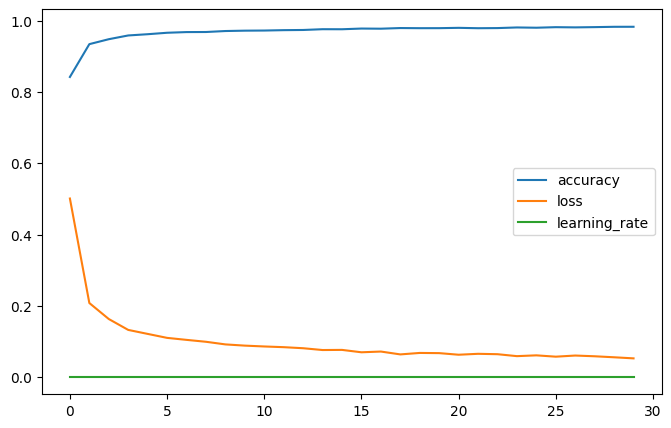

In [ ]:
# ------------------------------
# DL
# ------------------------------

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)

# Build CNN Model

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), kernel_initializer='he_normal', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.25),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

# Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

X_full = np.concatenate([X_train, X_val], axis=0)
y_full = np.concatenate([y_train, y_val], axis=0)

history = model.fit(
    datagen.flow(X_full, y_full, batch_size=128),
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# # Train the Model
# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=128),  # ✅ use augmented data
#     validation_data=(X_val, y_val),
#     epochs=30,  # you can go higher, early stopping will kick in
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8, 5))
plt.show()

# **STEP 5: Model Evaluation**

In [ ]:
# ------------------------------
# ML
# ------------------------------

# Define models and their hyperparameter grids
models_grid = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1],
            'solver': ['liblinear', 'lbfgs'],
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'param_grid': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_jobs=-1, random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
        'param_grid': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 4],
        }
    }
}

# Train and evaluate models
summary_list = []
best_estimators = {}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


for name, model_info in models_grid.items():
    print(f"🔍 Tuning: {name}")
    model = model_info['model']
    param_grid = model_info['param_grid']
    # for faster convergence and run (due to the large dataset)
    grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy',
        random_state=42
    )
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_val_scaled)

    summary_list.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "Accuracy": round(accuracy_score(y_val, y_pred), 4),
        "Precision": round(precision_score(y_val, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_val, y_pred, average='macro'), 4),
        "F1 Score": round(f1_score(y_val, y_pred, average='macro'), 4)
    })

    best_estimators[name] = best_model

# Create DataFrame and display
summary_df = pd.DataFrame(summary_list).sort_values(by='Accuracy', ascending=False)
summary_df

🔍 Tuning: Logistic Regression
🔍 Tuning: KNN
🔍 Tuning: Decision Tree
🔍 Tuning: Random Forest
🔍 Tuning: XGBoost


,Model,Best Params,Accuracy,Precision,Recall,F1 Score
4,XGBoost,"{'n_estimators': 100, 'max_depth': 4, 'learnin...",0.9710,0.9708,0.9707,0.9707
3,Random Forest,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.9664,0.9660,0.9661,0.9661
1,KNN,"{'weights': 'distance', 'n_neighbors': 3, 'met...",0.9546,0.9555,0.9540,0.9543
0,Logistic Regression,"{'solver': 'lbfgs', 'C': 0.01}",0.9180,0.9172,0.9167,0.9168
2,Decision Tree,"{'min_samples_split': 2, 'min_samples_leaf': 1...",0.8642,0.8625,0.8625,0.8624


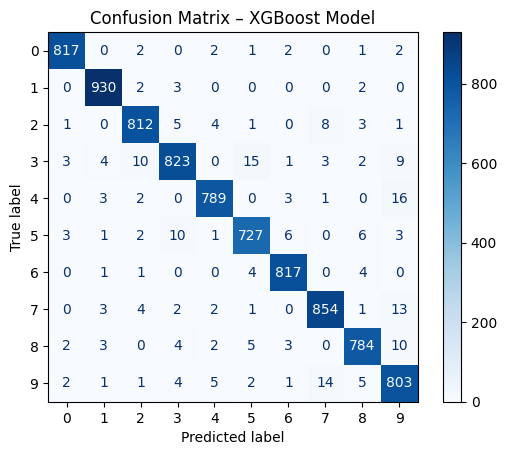

Classification Report – XGBoost Model
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       827
           1       0.98      0.99      0.99       937
           2       0.97      0.97      0.97       835
           3       0.97      0.95      0.96       870
           4       0.98      0.97      0.97       814
           5       0.96      0.96      0.96       759
           6       0.98      0.99      0.98       827
           7       0.97      0.97      0.97       880
           8       0.97      0.96      0.97       813
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [ ]:
# ------------------------------
# ML
# ------------------------------

# Choose based on summary_df or your evaluation results
best_model_name = summary_df.sort_values(by='F1 Score',ascending=False).iloc[0]['Model']
best_model = best_estimators[best_model_name]

# Evaluate
y_pred = best_model.predict(X_val_scaled)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_val_scaled, y_val, cmap='Blues')
plt.title(f"Confusion Matrix – {best_model_name} Model")
plt.show()

# Classification Report
print(f"Classification Report – {best_model_name} Model")
print(classification_report(y_val, y_pred))

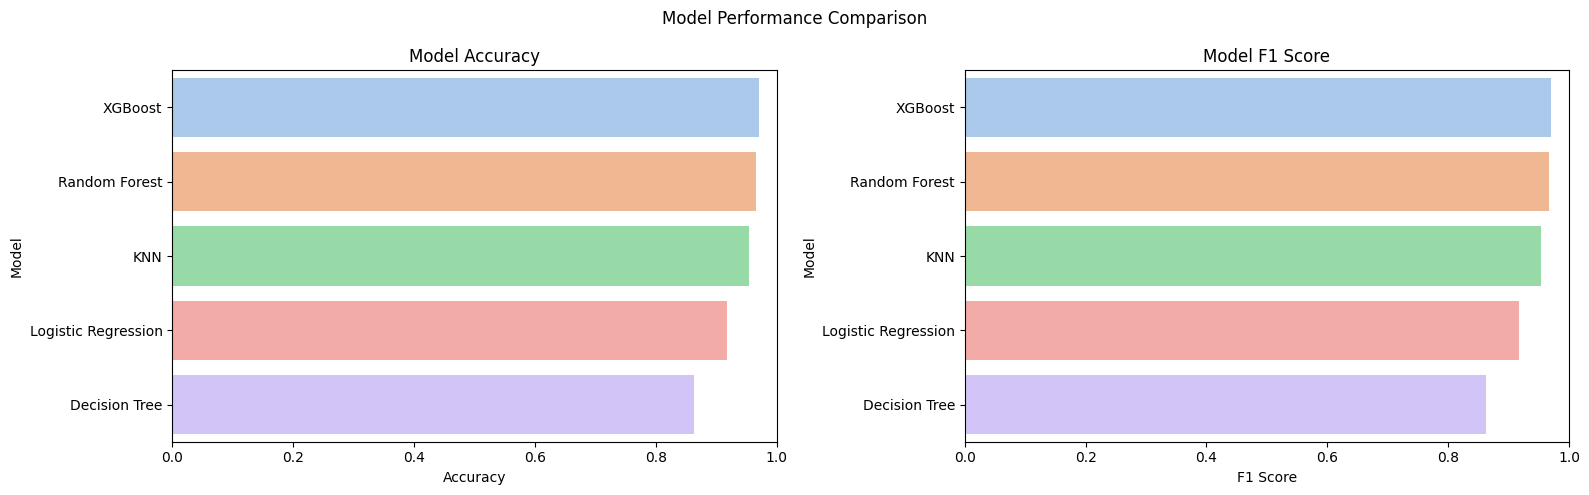

In [ ]:
# ------------------------------
# ML
# ------------------------------

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(y=summary_df['Model'], x=summary_df['Accuracy'], palette='pastel', ax=axes[0])
axes[0].set_title("Model Accuracy")
axes[0].set_xlim(0, 1)

sns.barplot(y=summary_df['Model'], x=summary_df['F1 Score'], palette='pastel', ax=axes[1])
axes[1].set_title("Model F1 Score")
axes[1].set_xlim(0, 1)

plt.suptitle("Model Performance Comparison")
plt.tight_layout()
plt.show()

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9926 - loss: 0.0247
✅ Final Validation Accuracy: 0.9925
✅ Final Validation Loss: 0.0228
****************************************


KeyError: 'val_accuracy'

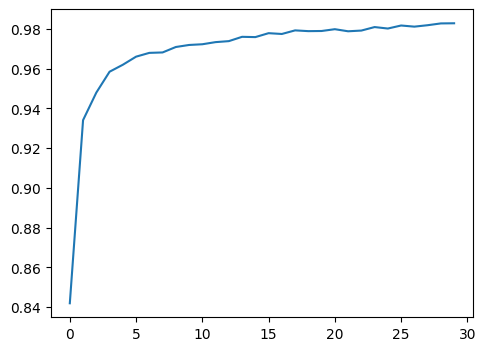

In [ ]:
# ------------------------------
# DL
# ------------------------------

# Evaluate model on validation set

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)

print(f"✅ Final Validation Accuracy: {val_accuracy:.4f}")
print(f"✅ Final Validation Loss: {val_loss:.4f}")
print("*" * 40)

# 📊 Plot Accuracy/Loss Curves

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()

# There is no significant sign of overfitting in these graphs, although slight fluctuations in validation accuracy and loss could indicate room for further improvement (e.g., through tuning, regularization, or more epochs).

In [ ]:
# ------------------------------
# ML
# ------------------------------

# save the model and scaler for deployment
joblib.dump(best_model, 'best_tuned_model.pkl')
print("✅ Model saved successfully.")

✅ Model saved successfully.


# **STEP 6: Model Deployment**

In [ ]:
# ------------------------------
# ML
# ------------------------------

# 6.1: combine train and validation sets
X_full = pd.concat([X_train,X_val])
y_full = pd.concat([y_train, y_val])

# 6.2: refit scaler on full data
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X_full)
X_test_scaled = final_scaler.transform(test)

# 6.3 Load best tuned model
best_model_name = summary_df.iloc[0]['Model']
best_model = best_estimators[best_model_name]

# 6.4 Retrain best model on full data
final_model = best_model.__class__(**best_model.get_params())  # copy tuned parameters
final_model = best_model.fit(X_full_scaled, y_full)

# 6.5 Predict on test set
test_predictions = final_model.predict(X_test_scaled)
test_predictions

# 6.6 Prepare submission file
submission = pd.read_csv("C:/Users/ARZ/Desktop/sample_submission.csv")
submission["Label"] = test_predictions
submission.to_csv("submission.csv", index=False)

# 6.7 Save final model and scaler
joblib.dump(final_model, "final_model.pkl")
joblib.dump(final_scaler, "final_scaler.pkl")

print(f"✅ Submission file saved as submission.csv")
print(f"✅ Final model saved as final_model.pkl")
print(f"✅ Final scaler saved as final_scaler.pkl")

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [ ]:
# ------------------------------
# DL
# ------------------------------

# 1️⃣ Save the trained CNN model
model.save("cnn_mnist_model.keras")
print("✅ Model saved as cnn_mnist_model.keras")

# 2️⃣ Prepare the test data (reshape + normalize)
X_test = test.values.astype("float32") / 255.0
X_test = X_test.reshape(-1, 28, 28, 1)
print(f"✅ Test data shape: {X_test.shape}")

# 3️⃣ Make predictions
pred_probs = model.predict(X_test)
pred_labels = np.argmax(pred_probs, axis=1)
print("✅ Predictions generated.")

# 4️⃣ Load the sample submission template
submission = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

# 5️⃣ Insert predictions
submission["Label"] = pred_labels

# 6️⃣ Save the submission file
submission.to_csv("cnn_submission.csv", index=False)
print("✅ Submission file saved as cnn_submission.csv")

✅ Model saved as cnn_mnist_model.keras
✅ Test data shape: (28000, 28, 28, 1)
875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step
✅ Predictions generated.
✅ Submission file saved as cnn_submission.csv
